In [1]:
%reload_ext autoreload

In [2]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import random
import csv
import pandas as pd

from fastai.imports import *
from fastai.structured import *
from matplotlib import pyplot
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import csv

sys.path.append('../lib')
import utils
import preprocessing

In [4]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [5]:
print(len(df_raw.loc[df_raw.churned == 0]), df_raw.loc[df_raw.churned == 0].shape)

df_processed = preprocessing.prepare_data(df_raw.loc[df_raw.licence_status != "STAGING"])
print(len(df_processed), df_processed.shape)

df_filtered = df_processed.loc[df_processed.churned == 0]
df_data, y_data, nas = proc_df(df_filtered, 'churned')
print(len(df_data), df_data.shape)

2780 (2780, 38)
Sorting dataframe by licence_registration_date ...
Converting annual_revenue to a number ...
Defaulting all NaN values with median ...
Defaulting annual_revenue for missing values to the plans mean or platform medeian ...
 Platform revenue median: 61729.175


../lib/preprocessing.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plan'][i] = "no_plan"
../lib/preprocessing.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plan_not_set'][i] = 1


Binning last_login_days
day          4636
month+        545
few_days       99
fortnight      96
week           88
month          83
Name: last_login_categories, dtype: int64
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
Preprocessing dates ...


../lib/preprocessing.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature][i] = random_replace_value(df, feature)


Dropping feature customer_account_status_Good ...
Dropping feature last_login_concern ...
Dropping feature last_login_days ...
Dropping feature account_status ...
Dropping feature changing_platform ...
Dropping feature new_platform ...
Dropping feature licence_status ...
Dropping feature canceldate ...
Dropping feature cancel_details ...
Dropping feature cancel_reason ...
Dropping feature url ...
Dropping feature merchant ...
Dropping feature total_churn_concern_cases_age ...
Dropping features with 'interactions' in their name ...
Dropping features with 'churn_concern' in their name ...
Convert categorical features into numbers ...
List any features that still have NaN values ...
5547 (5547, 96)
2438 (2438, 95)


//anaconda2/envs/fastai-cpu/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
joblib_file = "churn_model.pkl"

# Load from file
churn_model = joblib.load(joblib_file)

In [7]:
predictions = churn_model.predict(df_data)
probability = churn_model.predict_proba(df_data)[:,1]
len(probability), len(predictions), len(df_filtered)

(2438, 2438, 2438)

In [8]:
df_predictions = pd.DataFrame(predictions)
df_probability = pd.DataFrame(probability)

In [9]:
df_output = df_processed[df_processed.churned == 0].copy()

In [10]:
df_output['prediction'] = predictions
df_output['probability'] = probability

In [11]:
# Calculate churn concern %
churn_concern_count = len(df_output.loc[df_output['prediction'] == 1])
total_active = len(df_output)
churn_concern_percent = round((churn_concern_count / total_active) * 100, 2)
print(f"Churn concern count: {churn_concern_count} of {total_active} ({churn_concern_percent}%)")

Churn concern count: 52 of 2438 (2.13%)


In [12]:
# Sort churn concerns by probability
df_sorted = df_output.loc[df_output['prediction'] == 1].sort_values(by=['probability'], ascending=False)

In [13]:
#df_output.annual_revenue_log.var(), df_output.annual_revenue_log.skew(), df_output.annual_revenue_log.mad(), df_output.annual_revenue_log.mode()



In [106]:
df_raw[df_raw.username == df_sorted.username.iloc[i]].url.iloc[0]

'www.simplysheds.co.nz'

In [15]:
now = datetime.datetime.now()



for i in range(len(df_sorted.loc[df_sorted['probability'] > 0.551])):
#for i in range(len(df_sorted)):
    print(f"{now},{df_sorted.username.iloc[i]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].url.iloc[0]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].plan.iloc[0]},{df_sorted.licence_registration_Year.iloc[i]},{df_sorted.annual_revenue.iloc[i]},{df_sorted.probability.iloc[i]}")
    #with open('../data/predictions.csv', 'w') as writeFile:
    #    writer = csv.writer(writeFile)
    #    writer.writerows(sorted_array)

#writeFile.close()

2019-10-23 08:16:56.412233,N061491,marshall.neto.com.au,PLAN-360-17Q2,2018,0.0,0.7558510385582904
2019-10-23 08:16:56.412233,N040687,vantage-demo.neto.com.au,PLAN-360-17Q2,2018,45800.31,0.7540783058738738
2019-10-23 08:16:56.412233,N059446,tobias-tattoo-a.neto.com.au,CUSTOM,2018,0.0,0.7455343098353828
2019-10-23 08:16:56.412233,N061402,zoomautoparts.neto.com.au,PLAN-360-19Q1,2019,0.0,0.6746465950998815
2019-10-23 08:16:56.412233,N063144,www.sydneysupplies.com.au,PLAN-M-19Q1,2019,1843.2,0.668390536632146
2019-10-23 08:16:56.412233,N062334,www.uniquepartyshop.com.au,PLAN-M-19Q1,2019,4451.42,0.6670776539247778
2019-10-23 08:16:56.412233,N064484,www.hbvapour.nz,PLAN-360-19Q1,2019,16244.03,0.6358513149075882
2019-10-23 08:16:56.412233,N064207,www.myessentialhome.com.au,PLAN-S-19Q1,2019,0.0,0.5990018974555673
2019-10-23 08:16:56.412233,N065566,www.mypottedplants.com.au,PLAN-S-19Q1,2019,152.7,0.5982905994766639
2019-10-23 08:16:56.412233,N061994,invidia-exhausts.com.au,PLAN-S-19Q1,2019,70029.

In [100]:
n_number = 'N012287'
utils.display_all(df_filtered[df_filtered.username == n_number])

,username,days_active,team,vertical,salesperson,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,annual_revenue,churned,cases_total_was_nan,cases_open_was_nan,cases_closed_was_nan,cases_age_hours_total_was_nan,cases_age_hours_average_was_nan,last_login_days_was_nan,plan_not_set,annual_revenue_was_missing,last_login_categories,days_active_modified,customer_account_status_PoorStanding,plan_BASIC,plan_BRONZE,plan_BUSINESS,plan_BUSINESS +,plan_BUSINESS ONE,plan_CUSTOM,plan_CUSTOM XL,plan_ENTERPRISE,plan_GOLD,plan_GROW,plan_L&S - PREMIUM,plan_L&S - STANDARD,plan_L&S - ULTIMATE,plan_LIST N SEND SILVER,plan_LISTNSEND,plan_NETO XL,plan_PLAN-360-17Q2,plan_PLAN-360-19Q1,plan_PLAN-360-TRANSITION,plan_PLAN-360-US,plan_PLAN-L,plan_PLAN-L-17Q2,plan_PLAN-L-19Q1,plan_PLAN-M,plan_PLAN-M-17Q2,plan_PLAN-M-19Q1,plan_PLAN-M-US,plan_PLAN-S,plan_PLAN-S-17Q2,plan_PLAN-S-19Q1,plan_PLAN-S-US,plan_PLAN-XL-19Q1,plan_PLAN-XS,plan_PLAN-XS-17Q2,plan_PREMIUM,plan_STANDARD,plan_START,plan_START - LEGACY,plan_TRIAL,plan_ULTIMATE,plan_ULTIMATE PLUS,plan_no_plan,nps_no_data,nps_detractor,nps_passive,nps_promoter,licence_registration_Year,licence_registration_Month,licence_registration_Week,licence_registration_Day,licence_registration_Dayofweek,licence_registration_Dayofyear,licence_registration_Is_month_end,licence_registration_Is_month_start,licence_registration_Is_quarter_end,licence_registration_Is_quarter_start,licence_registration_Is_year_end,licence_registration_Is_year_start,licence_registration_Elapsed,golive_Year,golive_Month,golive_Week,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed
2327,N012287,1179,Neto XL,not specified,not specified,-1,5,0,0,1159,249,0.0,0,1,1,1,1,1,1,0,1,day,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2016,7,30,28,3,210,False,False,False,False,False,False,1469664000,1970,1,1,1,3,1,False,True,False,True,False,True,0


In [101]:
from eli5 import show_prediction
#df_output = df_sorted.drop(columns=['prediction', 'probability', 'churned'])
loc_address = df_filtered[df_filtered.username == n_number].index[0]
show_prediction(churn_model, df_data.loc[loc_address], show_feature_values=True)

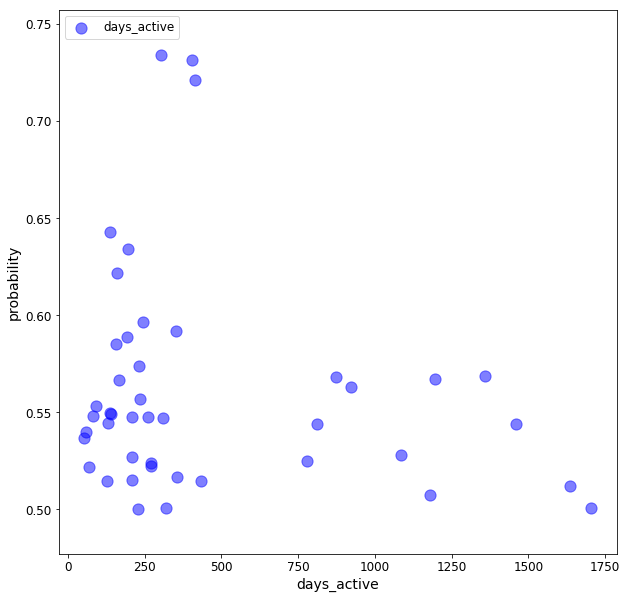

In [115]:
import matplotlib.pyplot as plt

feature='days_active'

plt.figure(figsize=(10,10))
plt.scatter(df_sorted[feature], df_sorted['probability'],
            c='b', marker='.', label=feature,
            s=500, alpha=.5)

plt.legend(loc='upper left')
plt.xlabel(feature)
plt.ylabel("probability")

plt.show()

In [17]:
print(df_sorted[feature].mode())

0    136
1    208
dtype: int64


In [18]:
def general_stats(df, feature):
    array = utils.data_summary_feature(df, feature)
    print(array[0])
    print("")
    count = 1
    for heading in ['Min', 'Max', 'Mean', 'Trimmed Mean', 'Median', 'Mode', 'Std', 'CV']:
        print(f"{heading}: {array[count]}")
        count += 1
        
general_stats(df_sorted,feature)

days_active

Min: 52
Max: 1705
Mean: 457.95454545454544
Trimmed Mean: 381.30555555555554
Median: 252.0
Mode: 0    136
1    208
dtype: int64
Std: 460.1027162642512
CV: 1.0046907948202013
